In [1]:
!git clone -qq https://github.com/facebookresearch/detr.git

In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
import json
import numpy as np 
import pandas as pd 
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder

import cv2

import sys
sys.path.append('./detr/')

from detr.models.matcher import HungarianMatcher
from detr.models.detr import SetCriterion

import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2

from glob import glob
from pprint import pprint

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Currently using "{device}" device')

Currently using "cuda" device


In [4]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
invTrans = T.Compose([T.Normalize(mean = [ 0., 0., 0. ],
                                  std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                      T.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                  std = [ 1., 1., 1. ]),
                      ])        

def _concat(x, y):
    """ Concat by the last dimension """
    if isinstance(x, np.ndarray):
        return np.concatenate((x, y), axis=-1)
    elif isinstance(x, torch.Tensor):
        return torch.cat([x, y], dim=-1)
    else:
        raise TypeError("unknown type '{}'".format(type(x)))

def xcycwh_to_xywh(xcycwh):
    """Convert [x_c y_c w h] box format to [x1, y1, w, h] format."""
    if isinstance(xcycwh, (list, tuple)):
        # Single box given as a list of coordinates
        assert not isinstance(xcycwh[0], (list, tuple))
        xc, yc = xcycwh[0], xcycwh[1]
        w = xcycwh[2]
        h = xcycwh[3]
        x1 = xc - w / 2.
        y1 = yc - h / 2.
        return [x1, y1, w, h]
    elif isinstance(xcycwh, (np.ndarray, torch.Tensor)):
        wh = xcycwh[..., 2:4]
        x1y1 = xcycwh[..., 0:2] - wh / 2.
        return _concat(x1y1, wh)
    else:
        raise TypeError('Argument xcycwh must be a list, tuple, or numpy array.')
        
def xywh_to_xyxy(xywh):
    """Convert [x1 y1 w h] box format to [x1 y1 x2 y2] format."""
    if isinstance(xywh, (list, tuple)):
        # Single box given as a list of coordinates
        assert len(xywh) == 4
        x1, y1 = xywh[0], xywh[1]
        x2 = x1 + np.maximum(0., xywh[2] - 1.)
        y2 = y1 + np.maximum(0., xywh[3] - 1.)
        return (x1, y1, x2, y2)
    elif isinstance(xywh, np.ndarray):
        # Multiple boxes given as a 2D ndarray
        return np.hstack(
            (xywh[:, 0:2], xywh[:, 0:2] + np.maximum(0, xywh[:, 2:4] - 1))
        )
    else:
        raise TypeError('Argument xywh must be a list, tuple, or numpy array.')

def xyxy_to_xcycwh(xyxy):
    """Convert [x1 y1 x2, y2] box format to [x_c y_c w h] format."""
    if isinstance(xyxy, (list, tuple)):
        # Single box given as a list of coordinates
        assert not isinstance(xyxy[0], (list, tuple))
        x1, y1 = xyxy[0], xyxy[1]
        w = xyxy[2] - x1
        h = xyxy[3] - y1
        x = (xyxy[0] + xyxy[2]) / 2.
        y = (xyxy[1] + xyxy[3]) / 2.
        return [x, y, w, h]
    elif isinstance(xyxy, (np.ndarray, torch.Tensor)):
        wh = xyxy[..., 2:4] - xyxy[..., 0:2]
        xy = (xyxy[..., 0:2] + xyxy[..., 2:4]) / 2.
        return _concat(xy, wh)
    else:
        raise TypeError('Argument xyxy must be a list, tuple, or numpy array.')

def xywh_to_xcycwh(xywh):
    """Convert [x1 y1 w h] box format to [x_c y_c w h] format."""
    if isinstance(xywh, (list, tuple)):
        # Single box given as a list of coordinates
        assert not isinstance(xywh[0], (list, tuple))
        x1, y1 = xywh[0], xywh[1]
        xc = x1 + np.maximum(0., xywh[2] / 2.)
        yc = y1 + np.maximum(0., xywh[3] )
        return [xc, yc, xywh[2], xywh[3]]

    elif isinstance(xywh, (np.ndarray, torch.Tensor)):
        wh = xywh[..., 2:4]
        xcyc = xywh[..., 0:2] + wh / 2
        return _concat(xcyc, wh)
    else:
        raise TypeError('Argument xyxy must be a list, tuple, numpy array, or tensor.')
        
def xyxy_to_xywh(xyxy):
    """Convert [x1 y1 x2 y2] box format to [x1 y1 w h] format."""
    if isinstance(xyxy, (list, tuple)):
        # Single box given as a list of coordinates
        assert len(xyxy) == 4
        x1, y1 = xyxy[0], xyxy[1]
        w = xyxy[2] - x1 + 1
        h = xyxy[3] - y1 + 1
        return (x1, y1, w, h)
    elif isinstance(xyxy, np.ndarray):
        # Multiple boxes given as a 2D ndarray
        return np.hstack((xyxy[:, 0:2], xyxy[:, 2:4] - xyxy[:, 0:2] + 1))
    else:
        raise TypeError('Argument xyxy must be a list, tuple, or numpy array.')

In [5]:
n_folds = 5
seed = 42
num_classes = 8 # 7 unique classes + background class
num_queries = 20 
null_class_coef = 1/num_classes
BATCH_SIZE = 4
IMAGE_SIZE = 512
LR = 1e-4 # 2e-5 
EPOCHS = 8

In [6]:
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(seed)

In [7]:
paths = r'../input/arthropod-taxonomy-orders-object-detection-dataset/ArTaxOr/'
annots = glob(paths + '/*/annotations/*.json')
annots = [str(annot) for annot in annots]

In [8]:
def create_dataframe(annots: list = annots) -> pd.DataFrame:
    array = np.zeros((1, 7), dtype=np.object)
    for i in tqdm(range(len(annots)), total=len(annots)):
        with open(annots[i], 'rb') as infile:
            data = json.load(infile)
            image_path = paths + data['asset'].get('path').split('ArTaxOr')[-1][1:]
            for item in data['regions']:
                row = np.zeros((1,7), dtype=np.object)
                row[0,0] = image_path
                row[0,1] = data['asset'].get('name')
                row[0,2] = item['tags'][0]
                row[0,3] = item['boundingBox'].get('height')
                row[0,4] = item['boundingBox'].get('width')
                row[0,5] = item['boundingBox'].get('left')
                row[0,6] = item['boundingBox'].get('top')
                array = np.concatenate([array, row], axis=0)
    df = pd.DataFrame(data=array[1:, :], columns=['path', 'image_id', 'label', 'height', 'width', 'left', 'top'])
    df[['height', 'width', 'left', 'top']] = df[['height', 'width', 'left', 'top']].astype(np.float32)
    return df

In [9]:
df = create_dataframe()
df[['xmin', 'ymin', 'xmax', 'ymax']] = xywh_to_xyxy(df[['left', 'top', 'width', 'height']].values)
enc = LabelEncoder()
df['class_id'] = enc.fit_transform(df['label'])

  0%|          | 0/15376 [00:00<?, ?it/s]

../input/arthropod-taxonomy-orders-object-detection-dataset/ArTaxOr/Lepidoptera/e03f338cf618.jpg


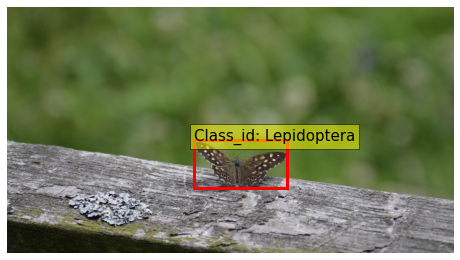

In [10]:
# coco bbox format
random_path = df['path'].sample(1).iloc[0]
df_random = df[df['path'] == random_path]
print(random_path)
sample_image = cv2.imread(random_path, cv2.IMREAD_COLOR)
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8,8))
plt.imshow(sample_image)
ax = plt.gca()

for idx, row in df_random.iterrows():
    x, y, w, h = row[['left', 'top', 'width', 'height']]
    ax.add_patch(plt.Rectangle((x, y), w, h,
                                fill=False, color='red', linewidth=3))
    text = f'Class_id: {row["label"]}'
    ax.text(x, y, text, fontsize=15,
            bbox=dict(facecolor='yellow', alpha=0.5))
plt.axis('off')
plt.show()

In [11]:
# get n_folded dataframe, stratified by number of bboxes, trying to preserve target-value counts
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)

df_folds = df[['image_id']].copy()
df_folds.loc[:, 'bbox_count'] = 1
df_folds = df_folds.groupby('image_id').count()
df_folds.loc[:, 'class_id'] = df[['image_id', 'class_id']].groupby('image_id').min()['class_id']
df_folds.loc[:, 'stratify_group'] = np.char.add(
    df_folds['class_id'].values.astype(str),
    df_folds['bbox_count'].apply(lambda x: f'_{x // ((num_classes-1)*2 + 1)}').values.astype(str)
)
df_folds.loc[:, 'fold'] = 0

for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index, y=df_folds['stratify_group'])):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number

In [12]:
def get_train_transforms():
    return A.Compose([A.OneOf([A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),      
                      A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.9)],p=0.5),
                      A.ToGray(p=0.01),
                      A.HorizontalFlip(p=0.1),
                      A.VerticalFlip(p=0.1),
                      A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE, p=1),
                      A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.2),
                      A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=1.0),
                      ToTensorV2(p=1.0),
                      ],p=1.0,
                      bbox_params=A.BboxParams(format='yolo', min_area=0, min_visibility=0, label_fields=['labels']),
                      )

def get_valid_transforms():
    return A.Compose([A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE, p=1.0),
                      A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=1.0),
                      ToTensorV2(p=1.0),
                     ], 
                      p=1.0, 
                      bbox_params=A.BboxParams(format='yolo', min_area=0, min_visibility=0, label_fields=['labels']),
                      )

In [13]:
class InsectDataset(Dataset):
    """ Define custom dataset class that returns an image tensor with corresponded target and image name"""
    def __init__(self, image_ids, df, transforms=None):
        self.image_ids = image_ids
        self.df = df
        self.transforms = transforms
        
    def __len__(self) -> int:
        return self.image_ids.shape[0]
    
    def __getitem__(self, index):
        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(records['path'].iloc[0], cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        h,w,_ = image.shape
        image /= 255.0
        
        boxes = records[['xmin', 'ymin', 'xmax', 'ymax']].values
        boxes[:, [0,2]] *= (IMAGE_SIZE / w)
        boxes[:, [1,3]] *= (IMAGE_SIZE / h)
        boxes = A.augmentations.bbox_utils.normalize_bboxes(boxes, IMAGE_SIZE, IMAGE_SIZE)
        boxes = np.array([xyxy_to_xcycwh(box) for box in boxes]) # yolo

        area = boxes[:,2] * boxes[:,3]
        area = torch.as_tensor(area, dtype=torch.float32)
        
        labels = records['class_id'].values.astype(np.int32)

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': boxes,
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            boxes = sample['bboxes']
            labels = sample['labels']
                                
        target = {}
        target['boxes'] = torch.as_tensor(boxes,dtype=torch.float32)
        target['labels'] = torch.as_tensor(labels,dtype=torch.long)
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        
        return image, target, image_id
    
    def collate_fn(self, batch):
        return tuple(zip(*batch))

#### Example

In [14]:
ds = InsectDataset(df_folds[df_folds['fold'] != 0].index.values, df, get_train_transforms())

[array([240, 178, 175, 156], dtype=int32), array([ 51, 138, 186, 177], dtype=int32)]


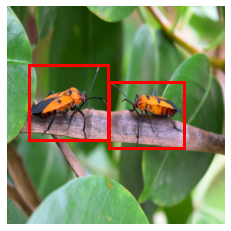

In [15]:
sample = ds[509]
img = invTrans(sample[0]).permute(1,2,0).cpu().numpy()
boxes = sample[1]['boxes'].cpu().numpy()
h,w,_ = img.shape
boxes = xcycwh_to_xywh(boxes)
boxes = [np.array(box).astype(np.int32) for box in A.augmentations.bbox_utils.denormalize_bboxes(boxes,h,w)]


print(boxes)
plt.imshow(img)
ax = plt.gca()

for box in boxes:
    x, y, w, h = box
    ax.add_patch(plt.Rectangle((x, y), w, h, fill=False, color='red', linewidth=3))
plt.axis('off')
plt.show()

#### continue 

<img src=attachment:0615207c-c4e1-4bf4-8397-3a201688bebf.png width=1000>
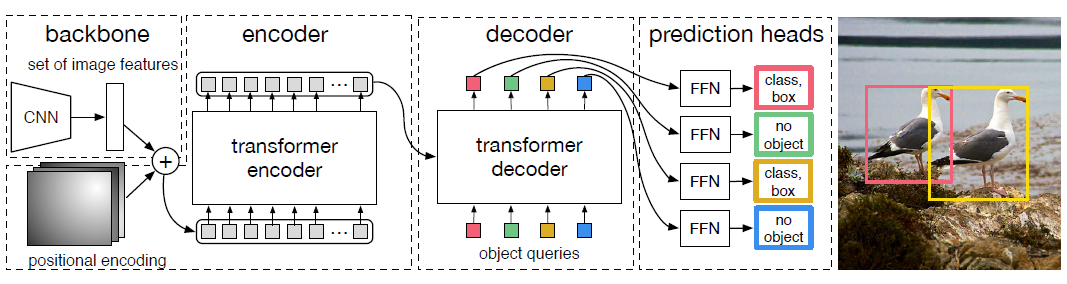

In [16]:
from detr.models.detr import MLP

class DETRModel(nn.Module):
    def __init__(self, num_classes, num_queries=None):
        super(DETRModel,self).__init__()
        self.num_classes = num_classes
        self.num_queries = num_queries
        
        self.model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
        self.in_features = self.model.class_embed.in_features
        
        for param in self.model.parameters():
            param.requires_grad = False
        
        self.model.class_embed = nn.Linear(in_features=self.in_features, out_features=self.num_classes)
        #self.model.num_queries = self.num_queries
        
        #self.model.query_embed = nn.Embedding(self.num_queries, 256)
        self.model.bbox_embed = MLP(256, 256, 4, 3)
        
    def forward(self,images):
        return self.model(images)

In [17]:
# second way

class DETRModelAdv(nn.Module):
    def __init__(self, num_classes, num_queries):
        super(DETRModel,self).__init__()
        self.num_classes = num_classes
        self.num_queries = num_queries
        
        self.model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=False, num_classes=50)
        checkpoint = torch.hub.load_state_dict_from_url(
                                    url='https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth',
                                    map_location=device,
                                    check_hash=True)
        del checkpoint["model"]["class_embed.weight"]
        del checkpoint["model"]["class_embed.bias"]
        self.model.load_state_dict(checkpoint["model"], strict=False)
        for param in self.model.parameters():
            param.requires_grad = False
        
        self.in_features = self.model.class_embed.in_features
        self.model.class_embed = nn.Linear(in_features=self.in_features, out_features=self.num_classes)
        self.model.bbox_embed = MLP(256, 256, 4, 3) # multilayer perceptron
        
    def forward(self,images):
        return self.model(images)

In [18]:
matcher = HungarianMatcher()

weight_dict = {'loss_ce': 1, 'loss_bbox': 1 , 'loss_giou': 1}

losses = ['labels', 'boxes', 'cardinality']

In [19]:
def train_fn(dataloader, model, criterion, optimizer, scheduler, epoch):
    model.train()
    criterion.train()
    
    summary_loss = AverageMeter()
    
    tk0 = tqdm(dataloader, total=len(dataloader), leave=True)
    
    for step, (images, targets, image_ids) in enumerate(tk0):
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        

        output = model(images)

        loss_dict = criterion(output, targets)
        weight_dict = criterion.weight_dict
        losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
        
        optimizer.zero_grad()

        losses.backward()
        optimizer.step()   
        
        summary_loss.update(losses.item(), BATCH_SIZE)
        tk0.set_postfix(loss=summary_loss.avg) # print out average losses after each epoch
    
    if scheduler is not None:
        scheduler.step() 
            
    return summary_loss

In [20]:
@torch.no_grad()
def eval_fn(dataloader, model, criterion):
    model.eval()
    criterion.eval()
    summary_loss = AverageMeter()
            
    tk0 = tqdm(dataloader, total=len(dataloader), leave=True)
    for step, (images, targets, image_ids) in enumerate(tk0):
            
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        output = model(images)

        loss_dict = criterion(output, targets)
        weight_dict = criterion.weight_dict
        
        losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
        summary_loss.update(losses.item(),BATCH_SIZE)
        tk0.set_postfix(loss=summary_loss.avg)
        
    return summary_loss

In [21]:
def run(fold):
    
    df_train = df_folds[df_folds['fold'] != fold]
    df_valid = df_folds[df_folds['fold'] == fold]
        
    train_dataset = InsectDataset(
                                  image_ids=df_train.index.values,
                                  df=df,
                                  transforms=get_train_transforms())

    valid_dataset = InsectDataset(
                                  image_ids=df_valid.index.values,
                                  df=df,
                                  transforms=get_valid_transforms())
    
    train_data_loader = DataLoader(
                                   train_dataset,
                                   batch_size=BATCH_SIZE,
                                   shuffle=False,
                                   num_workers=4,
                                   collate_fn=train_dataset.collate_fn)

    valid_data_loader = DataLoader(
                                   valid_dataset,
                                   batch_size=BATCH_SIZE,
                                   shuffle=False,
                                   num_workers=4,
                                   collate_fn=valid_dataset.collate_fn)
    
    model = DETRModel(num_classes=num_classes, num_queries=num_queries).to(device)
    # model.load_state_dict(torch.load("../input/detr-weights/detr_best_0.pth"))
    criterion = SetCriterion(num_classes-1, matcher, weight_dict, eos_coef=1/num_classes, losses=losses).to(device)    

    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-5)
    scheduler=torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5, verbose=True)
    
    best_loss = 10**5
    for epoch in range(EPOCHS):
        train_loss = train_fn(train_data_loader, model, criterion, optimizer,scheduler=scheduler, epoch=epoch)
        valid_loss = eval_fn(valid_data_loader, model, criterion)
        
        print('|EPOCH {}| TRAIN_LOSS {}| VALID_LOSS {}|'.format(epoch+1, train_loss.avg, valid_loss.avg))
        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            print('Best model found for Fold {} in Epoch {}........Saving Model'.format(fold, epoch+1))
            torch.save(model.state_dict(), f'detr_best_{fold}.pth')

In [22]:
for fold in range(5):
    run(fold)

Downloading: "https://github.com/facebookresearch/detr/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth" to /root/.cache/torch/hub/checkpoints/detr-r50-e632da11.pth


  0%|          | 0.00/159M [00:00<?, ?B/s]

Adjusting learning rate of group 0 to 1.0000e-04.


  0%|          | 0/3075 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


  0%|          | 0/769 [00:00<?, ?it/s]

|EPOCH 1| TRAIN_LOSS 1.0660728410298261| VALID_LOSS 0.8902890421789241|
Best model found for Fold 0 in Epoch 1........Saving Model


  0%|          | 0/3075 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


  0%|          | 0/769 [00:00<?, ?it/s]

|EPOCH 2| TRAIN_LOSS 0.8580964632150604| VALID_LOSS 0.8376817242841882|
Best model found for Fold 0 in Epoch 2........Saving Model


  0%|          | 0/3075 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.2500e-05.


  0%|          | 0/769 [00:00<?, ?it/s]

|EPOCH 3| TRAIN_LOSS 0.8225578190640706| VALID_LOSS 0.8057500146842902|
Best model found for Fold 0 in Epoch 3........Saving Model


  0%|          | 0/3075 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.2500e-06.


  0%|          | 0/769 [00:00<?, ?it/s]

|EPOCH 4| TRAIN_LOSS 0.8121013831995367| VALID_LOSS 0.8004256301257948|
Best model found for Fold 0 in Epoch 4........Saving Model


  0%|          | 0/3075 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.1250e-06.


  0%|          | 0/769 [00:00<?, ?it/s]

|EPOCH 5| TRAIN_LOSS 0.8045974835632294| VALID_LOSS 0.7929387989372829|
Best model found for Fold 0 in Epoch 5........Saving Model


  0%|          | 0/3075 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [23]:
# from torchvision.ops import nms  # nms is not needed as to the original paper and repo

def view_sample(frame, model, device, threshold=0.7):

    valid_dataset = InsectDataset(image_ids=frame.index.values,
                                  df=df,
                                  transforms=get_valid_transforms()
                                  )
     
    valid_data_loader = DataLoader(
                                    valid_dataset,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=4,
                                    collate_fn=valid_dataset.collate_fn)
    
    images, targets, image_ids = next(iter(valid_data_loader))
    _,h,w = images[0].shape
    images = list(img.to(device) for img in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    
    boxes = targets[0]['boxes'].cpu().numpy()
    boxes = xcycwh_to_xywh(boxes)
    boxes = [np.array(box).astype(np.int32) for box in A.augmentations.bbox_utils.denormalize_bboxes(boxes,h,w)]
    sample = invTrans(images[0]).permute(1,2,0).cpu().numpy()
    
    model.eval()
    model.to(device)
    cpu_device = torch.device("cpu")
    
    with torch.no_grad():
        outputs = model(images)
        
    outputs = {k: v.to(cpu_device) for k, v in outputs.items()}
    
    plt.figure(figsize=(16,8))
    ax = plt.gca()

    for box in boxes:
        ax.add_patch(plt.Rectangle((box[0], box[1]), box[2], box[3], fill=False, color='red', linewidth=2))
        
    probs = outputs['pred_logits'].softmax(-1).detach().cpu().numpy()[0, :, :-1] 
    keep = probs.max(-1) > threshold
    probs = probs[keep]
    
    oboxes = outputs['pred_boxes'].detach().cpu().numpy()[0, keep]
    oboxes = xcycwh_to_xywh(oboxes)
    oboxes = [np.array(box).astype(np.int32) for box in A.augmentations.bbox_utils.denormalize_bboxes(oboxes,h,w)]

    labels = outputs['pred_logits'][...,:-1].max(-1)[1].cpu().numpy()[0, keep]
    
    for box, prob, label in zip(oboxes, probs, labels):
        ax.add_patch(plt.Rectangle((box[0], box[1]), box[2], box[3], fill=False, color='blue', linewidth=2))
        text = f'Class_id: {enc.inverse_transform([label])}'
        ax.text(box[0], box[1], text, fontsize=10, bbox=dict(facecolor='yellow', alpha=0.5))
    
    ax.set_axis_off()
    ax.imshow(sample)
    
    return outputs

In [25]:
model = DETRModel(num_classes=num_classes,num_queries=num_queries)
model.load_state_dict(torch.load("../input/detr-weights/detr_best_0.pth"))

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_master


<All keys matched successfully>

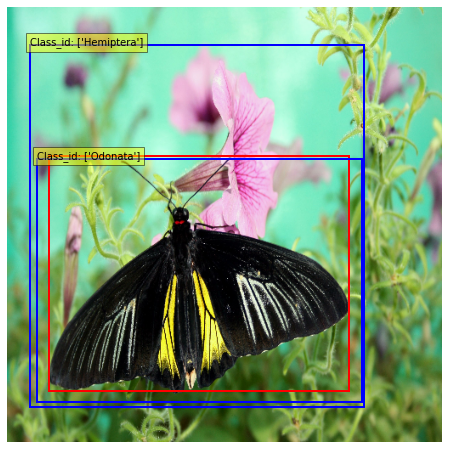

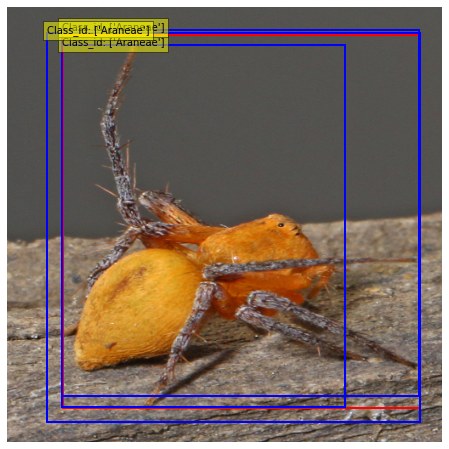

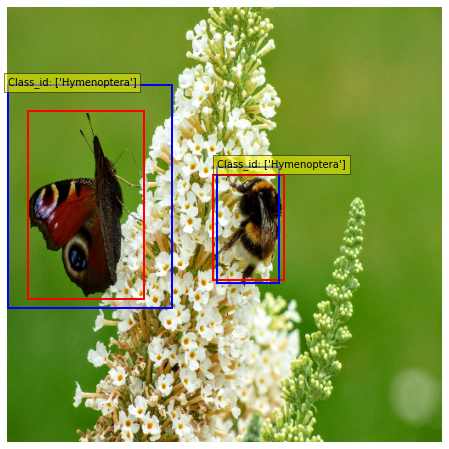

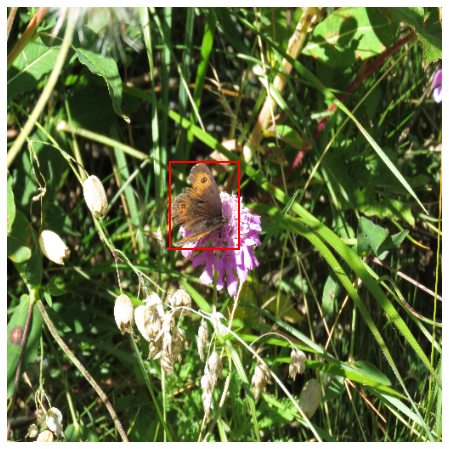

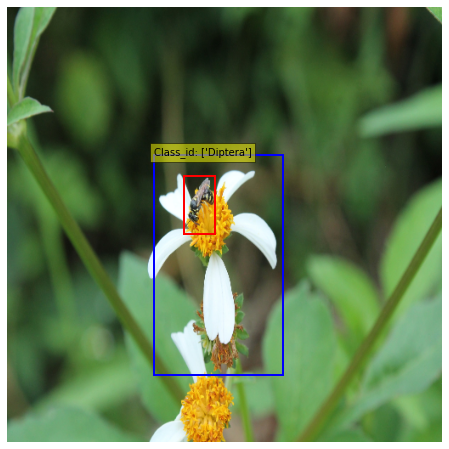

In [26]:
for i in range(5):
    view = view_sample(df_folds[df_folds['fold'] == i], model=model, device=device, threshold=0.06)